In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
from sublimpy import tidy
from sublimpy import extrautils
import glob

# Open data

## Fast data

In [3]:
file_list = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/*.nc")
file_list = [ f for f in file_list if '_20230418_' in f]
file_list = sorted(file_list)
file_list

['/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_00.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_01.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_02.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_03.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_04.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_05.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_06.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_07.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_20230418_08.nc',
 '/Users/elischwat/

In [4]:
ds = xr.open_mfdataset(file_list, concat_dim="time", combine="nested")

In [5]:
ds = ds[[
    'base_time',
    'u_3m_c',	'v_3m_c',	'w_3m_c',	'h2o_3m_c',		'tc_3m_c',
]]

## Planar fits files

In [6]:
monthly_file = "/Users/elischwat/Development/data/sublimationofsnow/monthly_planar_fits.csv"
weekly_file = "/Users/elischwat/Development/data/sublimationofsnow/weekly_planar_fits.csv"

In [7]:
fits_df = pd.read_csv(monthly_file, delim_whitespace=True)
weeklyfits_df = pd.read_csv(weekly_file, delim_whitespace=True)

fits_df['height'] = fits_df['height'].str.replace('_', '.').astype('float')
weeklyfits_df['start_date'] = pd.to_datetime(weeklyfits_df['start_date'], format='%Y%m%d')
weeklyfits_df['end_date'] = pd.to_datetime(weeklyfits_df['end_date'], format='%Y%m%d')

fits_df['W_f'] = fits_df.apply(
    lambda row: [row['W_f_1'], row['W_f_2'], row['W_f_3']],
    axis=1
).drop(columns=['W_f_1', 'W_f_2', 'W_f_3'])
weeklyfits_df['W_f'] = weeklyfits_df.apply(
    lambda row: [row['W_f_1'], row['W_f_2'], row['W_f_3']],
    axis=1
).drop(columns=['W_f_1', 'W_f_2', 'W_f_3'])

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13989/3479049279.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fits_df = pd.read_csv(monthly_file, delim_whitespace=True)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_13989/3479049279.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  weeklyfits_df = pd.read_csv(weekly_file, delim_whitespace=True)


# Create timestamp
To use the datam, its necessary to combine 3 columns of data from the dataset to get the full timestamp. This is demonstrated below. The 'time' column actually only incudes the second and minute information. For all datapoints, the hour according to the 'time' column is 1.  The 'base_time' column indicates the hour of the day. The 'sample' column indicates the 20hz sample number. 

We demonstrate this in the plots below

In [8]:
df1 = pd.DataFrame({'time': np.unique(ds['time'])})
df2 = pd.DataFrame({'base_time': np.unique(ds['base_time'])})
df3 = pd.DataFrame({'sample': np.unique(ds['sample'])})
(
    alt.Chart(df3).mark_tick(thickness=5).encode(
        alt.X("sample:Q").title(
            f'sample (n = {len(df3)})'
        )
    ).properties(width=600) & 

    alt.Chart(df1).mark_tick(thickness=1).encode(
        alt.X("time:T").axis(
            format='%H%M%p'
        ).title(
            f'time (n = {len(df1)})'
        )
    ).properties(width=600) & 

    alt.Chart(df2).mark_tick(thickness=5).encode(
        alt.X("base_time:T").title(
            f'base_time (n = {len(df2)})'
        )
    ).properties(width=600)
)

alt.VConcatChart(...)

In [9]:
df = ds.to_dataframe().reset_index()

In [10]:
df['time'] = df.apply(lambda row: dt.datetime(
        year = row['time'].year,
        month = row['time'].month,
        day = row['time'].day,
        hour = row['base_time'].hour,
        minute = row['time'].minute,
        second = row['time'].second,
        microsecond = int(row['sample'] * (1e6/20))
    ),
    axis = 1
)

In [52]:
ds = df.set_index('time').to_xarray()

In [53]:
ds = utils.modify_xarray_timezone(ds, 'UTC', "US/Mountain")

# Define function to do Reynolds Averaging

In [54]:
def create_re_avg_ds(
        ds, 
        re_avg_period_size, 
        var1,
        var2,
        covariance_name
):
    coarse_ds = ds.coarsen(time=re_avg_period_size).mean()
    coarse_ds = coarse_ds.assign_coords(time = coarse_ds.time.dt.round('1s'))
    coarse_ds = coarse_ds.reindex_like(ds, method='nearest')
    ds[f"{var1}_mean"] = coarse_ds[f"{var1}"]
    ds[f"{var1}_fluc"] = ds[f"{var1}"] - ds[f"{var1}_mean"]
    ds[f"{var2}_mean"] = coarse_ds[f"{var2}"]
    ds[f"{var2}_fluc"] = ds[f"{var2}"] - ds[f"{var2}_mean"]
    ds[covariance_name] = ds[f"{var2}_fluc"] * ds[f"{var1}_fluc"]
    ds = ds.coarsen(time = re_avg_period_size).mean()
    ds = ds.assign_coords(time = ds.time.dt.round('1s'))
    return ds

# Iterate over variables, apply planar fit to fast data, and calculate covariance fluxes

In [64]:
MONTH = ds.time.dt.month.values[0]

RE_AVG_PD_DATA_SAMPLES = 36000

tower = 'c'
height = 3

fitting_params = fits_df.set_index(['month', 'height', 'tower']).loc[
    MONTH,
    height,
    tower
]
u, v, w = extrautils.apply_planar_fit(
    ds[f'u_{height}m_{tower}'].values.flatten(),
    ds[f'v_{height}m_{tower}'].values.flatten(),
    ds[f'w_{height}m_{tower}'].values.flatten(),
    fitting_params['a'], 
    fitting_params['W_f'],
)
ds[f'u_{height}m_{tower}'] = ('time', u)
ds[f'v_{height}m_{tower}'] = ('time', v)
ds[f'w_{height}m_{tower}'] = ('time', w)

coarse_ds = ds.coarsen(time=RE_AVG_PD_DATA_SAMPLES).mean()
coarse_ds['theta'] = np.arctan2(coarse_ds[f'v_{height}m_{tower}'], coarse_ds[f'u_{height}m_{tower}'])
coarse_ds = coarse_ds.assign_coords(time = coarse_ds.time.dt.round('1s'))
coarse_ds = coarse_ds.reindex_like(ds, method='nearest')

ds[f'u_{height}m_{tower}'] = ds[f'u_{height}m_{tower}']*np.cos(coarse_ds['theta']) + ds[f'v_{height}m_{tower}']*np.sin(coarse_ds['theta'])
ds[f'v_{height}m_{tower}'] = -ds[f'u_{height}m_{tower}']*np.sin(coarse_ds['theta']) + ds[f'v_{height}m_{tower}']*np.cos(coarse_ds['theta'])
ds[f'w_{height}m_{tower}'] = ds[f'w_{height}m_{tower}']

ds_u = create_re_avg_ds(
    ds, 
    RE_AVG_PD_DATA_SAMPLES, 
    var1 = f'u_{height}m_{tower}',
    var2= f'u_{height}m_{tower}',
    covariance_name = f'u_u__{height}m_{tower}'
)
ds_v = create_re_avg_ds(
    ds, 
    RE_AVG_PD_DATA_SAMPLES, 
    var1 = f'v_{height}m_{tower}',
    var2= f'v_{height}m_{tower}',
    covariance_name = f'v_v__{height}m_{tower}'
)

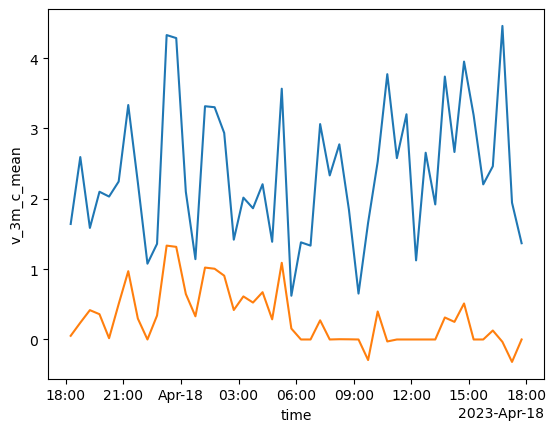

In [65]:
ds_u['u_3m_c_mean'].plot()
ds_v['v_3m_c_mean'].plot()

In [71]:
fs = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/double_rotated_30min_despiked_q7/*.parquet")
fs = [f for f in fs if '20230418' in f]
df = pd.read_parquet(fs).sort_index()

<Axes: xlabel='time'>

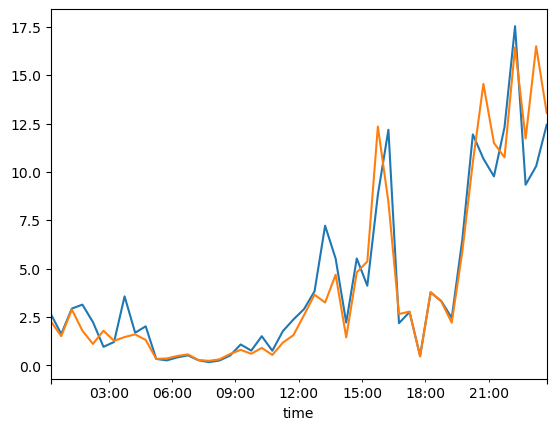

In [81]:
df['u_u__3m_c'].plot()
df['u_u__3m_c_fit'].plot()

<Axes: xlabel='time'>

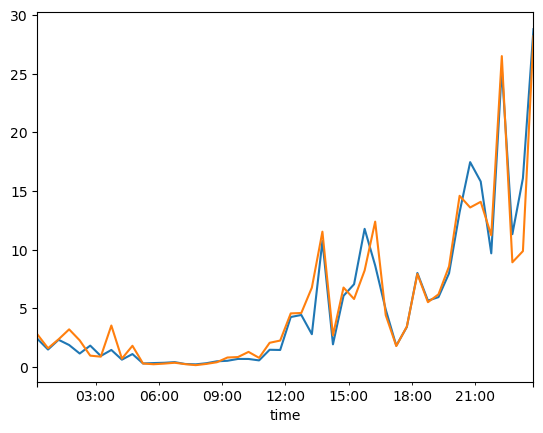

In [82]:
df['v_v__3m_c'].plot()
df['v_v__3m_c_fit'].plot()

In [113]:
df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/planar_fit/20221101.parquet")